# CS175 project: Generative Conversational Chatbot by nlpnet
## Preparations

In [1]:
# !pip install emoji

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import csv
import random
import warnings
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math
import json
import pandas as pd
import emoji
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None 

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device check: {device}')

Device check: cuda


## Load & Preprocess Datasets
    Reference:
        https://pytorch.org/tutorials/beginner/chatbot_tutorial.html

### The Cornell Movie-Dialogs Corpus

In [4]:
# Splits each line of the file to create lines and conversations
def loadLinesAndConversations(fileName):
    lines = {}
    conversations = {}
    with open(fileName, 'r', encoding='iso-8859-1') as f:
        for line in f:
            lineJson = json.loads(line)
            # Extract fields for line object
            lineObj = {}
            lineObj["lineID"] = lineJson["id"]
            lineObj["characterID"] = lineJson["speaker"]
            lineObj["text"] = lineJson["text"]
            lines[lineObj['lineID']] = lineObj

            # Extract fields for conversation object
            if lineJson["conversation_id"] not in conversations:
                convObj = {}
                convObj["conversationID"] = lineJson["conversation_id"]
                convObj["movieID"] = lineJson["meta"]["movie_id"]
                convObj["lines"] = [lineObj]
            else:
                convObj = conversations[lineJson["conversation_id"]]
                convObj["lines"].insert(0, lineObj)
            conversations[convObj["conversationID"]] = convObj

    return lines, conversations


# Extracts pairs of sentences from conversations
def extractSentencePairs(conversations):
    qa_pairs = []
    for conversation in conversations.values():
        # Iterate over all the lines of the conversation
        for i in range(len(conversation["lines"]) - 1):  # We ignore the last line (no answer for it)
            inputLine = conversation["lines"][i]["text"].strip()
            targetLine = conversation["lines"][i+1]["text"].strip()
            # Filter wrong samples (if one of the lists is empty)
            if inputLine and targetLine:
                qa_pairs.append([inputLine, targetLine])
    return qa_pairs

In [5]:
# Define path to new file
corpus = 'cornell-movie-corpus'
corpus_name = corpus
datafile = os.path.join(corpus, "formatted_movie_lines.txt")

delimiter = '\t'
# Unescape the delimiter
delimiter = str(codecs.decode(delimiter, "unicode_escape"))

# Initialize lines dict and conversations dict
lines = {}
conversations = {}
# Load lines and conversations
print("\nProcessing corpus into lines and conversations...")
lines, conversations = loadLinesAndConversations(os.path.join(corpus, "utterances.jsonl"))

# Write new csv file
print("\nWriting newly formatted file...")
with open(datafile, 'w', encoding='utf-8') as outputfile:
    writer = csv.writer(outputfile, delimiter=delimiter, lineterminator='\n')
    for pair in extractSentencePairs(conversations):
        writer.writerow(pair)
print('Done.')


Processing corpus into lines and conversations...

Writing newly formatted file...
Done.


## Load and trim data
    Reference:
        https://pytorch.org/tutorials/beginner/chatbot_tutorial.html

In [6]:
# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 # Count default tokens

        for word in keep_words:
            self.addWord(word)

In [7]:
MAX_LENGTH = 25  # Maximum sentence length to consider

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

# Read query/response pairs and return a voc object
def readVocs(datafile, corpus_name):
    print("Reading lines...")
    # Read the file and split into lines
    lines = open(datafile, encoding='utf-8').\
        read().strip().split('\n')
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    voc = Voc(corpus_name)
    return voc, pairs

# Returns True iff both sentences in a pair 'p' are under the MAX_LENGTH threshold
def filterPair(p):
    # Input sequences need to preserve the last word for EOS token
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

# Filter pairs using filterPair condition
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# Using the functions defined above, return a populated voc object and pairs list
def loadPrepareData(corpus, corpus_name, datafile, save_dir):
    print("Start preparing training data ...")
    voc, pairs = readVocs(datafile, corpus_name)
    print("Read {!s} sentence pairs".format(len(pairs)))
    pairs = filterPairs(pairs)
    print("Trimmed to {!s} sentence pairs".format(len(pairs)))
    print("Counting words...")
    for pair in pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
    print("Counted words:", voc.num_words)
    return voc, pairs


# Load/Assemble voc and pairs
save_dir = os.path.join("data", "save")
voc, pairs = loadPrepareData(corpus, corpus_name, datafile, save_dir)
# Print some pairs to validate
print('Amount of pairs:', len(pairs))

print("\npairs:")
for pair in pairs[:10]:
    print(pair)

Start preparing training data ...
Reading lines...
Read 221282 sentence pairs
Trimmed to 168840 sentence pairs
Counting words...
Counted words: 37402
Amount of pairs: 168840

pairs:
['they do to !', 'they do not !']
['she okay ?', 'i hope so .']
['wow', 'let s go .']
['i m kidding . you know how sometimes you just become this persona ? and you don t know how to quit ?', 'no']
['no', 'okay you re gonna need to learn how to lie .']
['i figured you d get to the good stuff eventually .', 'what good stuff ?']
['what good stuff ?', 'the real you .']
['the real you .', 'like my fear of wearing pastels ?']
['do you listen to this crap ?', 'what crap ?']
['what crap ?', 'me . this endless . . .blonde babble . i m like boring myself .']


### Microsoft Research WikiQA Corpus Preprocessing & Merging with the list of pairs
    Codes written by ourselves.

In [8]:
Wiki_df = pd.read_csv('WikiQACorpus/WikiQA.tsv',sep = '\t')

flitered_df = Wiki_df[Wiki_df['Label'] == 1] 
flitered_df.reset_index(drop=True, inplace=True)

flitered_df.drop(columns = ['QuestionID'], inplace = True)
flitered_df.drop(columns = ['DocumentID'], inplace = True)
flitered_df.drop(columns = ['DocumentTitle'], inplace = True)
flitered_df.drop(columns = ['SentenceID'], inplace = True)
flitered_df.drop(columns = ['Label'], inplace = True)

flitered_df.to_csv('WikiQACorpus/flitered_WikiQA', sep='\t')
flitered_df.head(10)

,Question,Sentence
0,HOW AFRICAN AMERICANS WERE IMMIGRATED TO THE US,"As such, African immigrants are to be distingu..."
1,how are glacier caves formed?,A glacier cave is a cave formed within the ice...
2,how a water pump works,Pumps operate by some mechanism (typically rec...
3,"how big is bmc software in houston, tx","Employing over 6,000, BMC is often credited wi..."
4,"how big is bmc software in houston, tx","For 2011, the company recorded an annual reven..."
5,how much is 1 tablespoon of water,This tablespoon has a capacity of about 15 mL.
6,how much is 1 tablespoon of water,In the USA one tablespoon (measurement unit) i...
7,how much is 1 tablespoon of water,In Australia one tablespoon (measurement unit)...
8,how much are the harry potter movies worth,The series also originated much tie-in merchan...
9,how a rocket engine works,"A rocket engine, or simply ""rocket"", is a jet ..."


In [9]:
# Microsoft Research WikiQA Corpus
corpus2 = 'WikiQACorpus'
corpus2_name = corpus2
datafile2 = os.path.join(corpus2, "flitered_WikiQA")
voc2, pairs2 = loadPrepareData(corpus2, corpus2_name, datafile2, save_dir)

# merge the voc togther 
voc.word2index.update(voc2.word2index)

# reformat the new pair before merging
pairs2 = pairs2[1:]
pairs2 = [ lst[1:] for lst in pairs2 ] 
print(pairs2[:10])

# merge the pairs togther 
pairs += pairs2
print(len(pairs))

Start preparing training data ...
Reading lines...
Read 1470 sentence pairs
Trimmed to 1470 sentence pairs
Counting words...
Counted words: 2464
[['how african americans were immigrated to the us', 'as such african immigrants are to be distinguished from african american people the latter of whom are descendants of mostly west and central africans who were involuntarily brought to the united states by means of the historic atlantic slave trade .'], ['how are glacier caves formed ?', 'a glacier cave is a cave formed within the ice of a glacier .'], ['how a water pump works', 'pumps operate by some mechanism typically reciprocating or rotary and consume energy to perform mechanical work by moving the fluid .'], ['how big is bmc software in houston tx', 'employing over bmc is often credited with pioneering the bsm concept as a way to help better align it operations with business needs .'], ['how big is bmc software in houston tx', 'for the company recorded an annual revenue of . billion m

### Twitter Conversational Corpus Preprocessing & Merging the vocabulary and the list of pairs
    Modified the pre-existed function and add codes that written by ourseleves.
    Reference: https://pytorch.org/tutorials/beginner/chatbot_tutorial.html

In [10]:
corpus3 = 'TwitterCorpus'
corpus3_name = corpus3
datafile3 = os.path.join(corpus3, "chat.txt")

In [11]:
def printLines(file, n=5):
    with open(file, 'rb') as datafile:
        lines = datafile.readlines()
    for line in lines[:n]:
        print(line)

        
def loadPrepareTwitterData(corpus_name, datafile):
    print("Start preparing training data ...")
    voc, pairs = readVocs(datafile, corpus_name)
    print("Read {!s} sentence pairs".format(len(pairs)))
    pairs = filterPairs(pairs)
    print("Trimmed to {!s} sentence pairs".format(len(pairs)))
    print("Counting words...")
    for pair in pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
    print("Counted words:", voc.num_words)
    return voc, pairs

        
def extractSentencePairs_T(fileName):
    qa_pairs = []
    inputLine=''
    targetLine=''
    check=False
    with open(fileName, 'r', encoding='UTF-8') as f:
        for count,line in enumerate(f):
            count += 1
            if (count % 2) == 0:
                targetLine = emoji.replace_emoji(line, replace='')
                targetLine = targetLine.strip()
                check = True
            else:
                inputLine = emoji.replace_emoji(line, replace='')
                inputLine = inputLine.strip()
                check = False
            
            if check:
                qa_pairs.append([inputLine, targetLine])

        
    return qa_pairs

In [12]:
delimiter = '\t'
# Unescape the delimiter
delimiter = str(codecs.decode(delimiter, "unicode_escape"))

print("\nWriting newly formatted file...")
with open('TwitterCorpus/reformatted_chat.txt', 'w', encoding='utf-8') as outputfile:
    writer = csv.writer(outputfile, delimiter=delimiter, lineterminator='\n')
    for pair in extractSentencePairs_T(datafile3):
#         if '.' in pair[0]:
#             pair[0] = pair[0].replace('.', '')
#         if '.' in pair[1]:
#             pair[1] = pair[1].replace('.', '')
        writer.writerow(pair)
    
print("\nSample lines from file:")
printLines('TwitterCorpus/reformatted_chat.txt')


Writing newly formatted file...

Sample lines from file:
b"yeah i'm preparing myself to drop a lot on this man, but definitely need something reliable\tyeah dude i would definitely consider a daniel defence super reliable and they are just bad ass\r\n"
b"i'm about to meet my mans ex friend with benefit, tune in next week to see if i have to put hands on\ti'm dead not looking forward to this\r\n"
b"shouldn't the supporter's natural answer to 's hashtag be ?\tor just insert itl to make .\r\n"
b'you want to turn twitter followers into blog readers.\thow do you do this?\r\n'
b"besides if trump say his condolences it won't sound genuine, ex: (dwayne wade cousin) it will sound all political and petty\tyea you right. but we do live in a world where republicans will harass obama about a birth certificate but won't say\r\n"


In [13]:
voc3, pairs3 = loadPrepareTwitterData(corpus3, 'TwitterCorpus/reformatted_chat.txt')
# Print some pairs to validate
print("\npairs:")
for pair3 in pairs3[:10]:
    print(pair3)
# print(voc3.word2index)

Start preparing training data ...
Reading lines...
Read 377265 sentence pairs
Trimmed to 307064 sentence pairs
Counting words...
Counted words: 111038

pairs:
['yeah i m preparing myself to drop a lot on this man but definitely need something reliable', 'yeah dude i would definitely consider a daniel defence super reliable and they are just bad ass']
['i m about to meet my mans ex friend with benefit tune in next week to see if i have to put hands on', 'i m dead not looking forward to this']
['shouldn t the supporter s natural answer to s hashtag be ?', 'or just insert itl to make .']
['you want to turn twitter followers into blog readers .', 'how do you do this ?']
['besides if trump say his condolences it won t sound genuine ex dwayne wade cousin it will sound all political and petty', 'yea you right . but we do live in a world where republicans will harass obama about a birth certificate but won t say']
['well i finally finished watching all the episodes of breaking the magician s c

In [14]:
# merge the voc togther 
voc.word2index.update(voc3.word2index)

# merge the pairs togther 
pairs += pairs3
print(len(pairs))

477373


### Eliminating most of the marks from really short answers
    Codes written by ourselves.

In [15]:
for lst in pairs:
    if len(lst[1].split()) <= 3:
        lst[1] = lst[1].replace('.', '')
        lst[1] = lst[1].replace('?', '')
        lst[1] = lst[1].replace('!', '')
print(pairs[:10])

[['they do to !', 'they do not !'], ['she okay ?', 'i hope so .'], ['wow', 'let s go .'], ['i m kidding . you know how sometimes you just become this persona ? and you don t know how to quit ?', 'no'], ['no', 'okay you re gonna need to learn how to lie .'], ['i figured you d get to the good stuff eventually .', 'what good stuff ?'], ['what good stuff ?', 'the real you .'], ['the real you .', 'like my fear of wearing pastels ?'], ['do you listen to this crap ?', 'what crap '], ['what crap ?', 'me . this endless . . .blonde babble . i m like boring myself .']]


### Achieving faster convergence during training by trimming rarely used words out of our vocabulary
    Modified the pre-existed function and add codes that written by ourseleves.
    Reference:
        https://pytorch.org/tutorials/beginner/chatbot_tutorial.html

In [16]:
MIN_COUNT = 5   # Minimum word count threshold for trimming

def trimRareWords(voc, pairs, MIN_COUNT):
    # Trim words used under the MIN_COUNT from the voc
    voc.trim(MIN_COUNT)
    # Filter out pairs with trimmed words
    keep_pairs = []
    for pair in pairs:
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        # Check input sentence
        for word in input_sentence.split(' '):
            if word not in voc.word2index:
                keep_input = False
                break
        # Check output sentence
        for word in output_sentence.split(' '):
            if word not in voc.word2index:
                keep_output = False
                break

        # Only keep pairs that do not contain trimmed word(s) in their input or output sentence
        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("Trimmed from {} pairs to {}, {:.4f} of total".format(len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
    return keep_pairs


# Trim voc and pairs
pairs = trimRareWords(voc, pairs, MIN_COUNT)

keep_words 14285 / 120815 = 0.1182
Trimmed from 477373 pairs to 187731, 0.3933 of total


## Transform to numerical torch tensors as inputs
    Reference:
        https://pytorch.org/tutorials/beginner/chatbot_tutorial.html

In [17]:
def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]


def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

# Returns padded input sequence tensor and lengths
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

# Returns padded target sequence tensor, padding mask, and max target length
def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.BoolTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

# Returns all items for a given batch of pairs
def batch2TrainData(voc, pair_batch):
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len


# Example for validation
small_batch_size = 5
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches

print("input_variable:", input_variable)
print("lengths:", lengths)
print("target_variable:", target_variable)
print("mask:", mask)
print("max_target_len:", max_target_len)

input_variable: tensor([[  137,  1086,   336,   155,  1765],
        [  110,  4090,    42,    39,  5860],
        [   84,  4230,    14,     3,  4989],
        [ 4424,   288,   154,   413,    14],
        [12848,  3575,    17,   317,     2],
        [   14,    66, 10416,    10,     0],
        [   16,   287,    14,     2,     0],
        [   17,    14,     2,     0,     0],
        [  461,    14,     0,     0,     0],
        [   28,    14,     0,     0,     0],
        [  291,     2,     0,     0,     0],
        [  263,     0,     0,     0,     0],
        [   14,     0,     0,     0,     0],
        [    2,     0,     0,     0,     0]])
lengths: tensor([14, 11,  8,  7,  5])
target_variable: tensor([[   41,    32,    23,    41,   123],
        [  337,    14,   179,  1446,    41],
        [  137,   211,     8,  2571,  1438],
        [   14,   288,   555,    14,  4041],
        [  137,  1408,    27,     2,   889],
        [   17,     5,    10,     0,    21],
        [  251,    54,    27

## Defining Seq2Seq model, training, and chatbot conversation
    Modified the pre-existed function and add codes that written by ourseleves.
    Reference:
        https://pytorch.org/tutorials/beginner/chatbot_tutorial.html

In [18]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size params are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # Convert word indexes to embeddings
        embedded = self.embedding(input_seq)
        # Pack padded batch of sequences for RNN module
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        # Sum bidirectional GRU outputs
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        # Return output and final hidden state
        return outputs, hidden

In [19]:
# Luong attention layer
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

In [20]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # Note: we run this one step (word) at a time
        # Get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # Return output and final hidden state
        return output, hidden

In [21]:
def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

In [22]:
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip, max_length=MAX_LENGTH):

    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Set device options
    input_variable = input_variable.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)
    # Lengths for rnn packing should always be on the cpu
    lengths = lengths.to("cpu")

    # Initialize variables
    loss = 0
    print_losses = []
    n_totals = 0

    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    # Determine if we are using teacher forcing this iteration
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Forward batch of sequences through decoder one time step at a time
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # Teacher forcing: next input is current target
            decoder_input = target_variable[t].view(1, -1)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # No teacher forcing: next input is decoder's own current output
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    # Perform backpropatation
    loss.backward()

    # Clip gradients: gradients are modified in place
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals

In [23]:
def trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size, print_every, save_every, clip, corpus_name, loadFilename):

    # Load batches for each iteration
    training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]

    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    if loadFilename:
        start_iteration = checkpoint['iteration'] + 1

    # Training loop
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        # Extract fields from batch
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        # Run a training iteration with batch
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip)
        print_loss += loss

        # Print progress
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0

        # Save checkpoint
        if (iteration % save_every == 0):
            directory = os.path.join(save_dir, model_name, corpus_name, '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size))
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss': loss,
                'voc_dict': voc.__dict__,
                'embedding': embedding.state_dict()
            }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))

In [24]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        # Forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # Prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        # Iteratively decode one word token at a time
        for _ in range(max_length):
            # Forward pass through decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Obtain most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # Record token and score
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # Prepare current token to be next decoder input (add a dimension)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # Return collections of word tokens and scores
        return all_tokens, all_scores

In [25]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
    ### Format input sentence as a batch
    # words -> indexes
    indexes_batch = [indexesFromSentence(voc, sentence)]
    # Create lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # Transpose dimensions of batch to match models' expectations
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    # Use appropriate device
    input_batch = input_batch.to(device)
    lengths = lengths.to("cpu")
    # Decode sentence with searcher
    tokens, scores = searcher(input_batch, lengths, max_length)
    # indexes -> words
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words

In [26]:
# Configure models
model_name = 'cb_model'
attn_model = 'dot'
# attn_model = 'general'
# attn_model = 'concat'
hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 64

# Set checkpoint to load from; set to None if starting from scratch
loadFilename = None
checkpoint_iter = 2000
#loadFilename = os.path.join(save_dir, model_name, corpus_name,
#                            '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size),
#                            '{}_checkpoint.tar'.format(checkpoint_iter))


# Load model if a loadFilename is provided
if loadFilename:
    # If loading on same machine the model was trained on
    checkpoint = torch.load(loadFilename)
    # If loading a model trained on GPU to CPU
    #checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    voc.__dict__ = checkpoint['voc_dict']


print('Building encoder and decoder ...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, hidden_size)
if loadFilename:
    embedding.load_state_dict(embedding_sd)
# Initialize encoder & decoder models
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)
# Use appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)
print('Models built and ready to go!')

Building encoder and decoder ...
Models built and ready to go!


In [27]:
# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 10000
print_every = 1000
save_every = 2000

# Ensure dropout layers are in train mode
encoder.train()
decoder.train()

# Initialize optimizers
print('Building optimizers ...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
if loadFilename:
    encoder_optimizer.load_state_dict(encoder_optimizer_sd)
    decoder_optimizer.load_state_dict(decoder_optimizer_sd)

# If you have cuda, configure cuda to call
for state in encoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

for state in decoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

# Run training iterations
print("Starting Training!")
trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, corpus_name, loadFilename)

Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 1000; Percent complete: 10.0%; Average loss: 4.9394
Iteration: 2000; Percent complete: 20.0%; Average loss: 4.4073
Iteration: 3000; Percent complete: 30.0%; Average loss: 4.2613
Iteration: 4000; Percent complete: 40.0%; Average loss: 4.1673
Iteration: 5000; Percent complete: 50.0%; Average loss: 4.1037
Iteration: 6000; Percent complete: 60.0%; Average loss: 4.0503
Iteration: 7000; Percent complete: 70.0%; Average loss: 3.9879
Iteration: 8000; Percent complete: 80.0%; Average loss: 3.9488
Iteration: 9000; Percent complete: 90.0%; Average loss: 3.9103
Iteration: 10000; Percent complete: 100.0%; Average loss: 3.8614


## Model Evaluation
    modified the pre-existed function and add codes that written by ourseleves.

In [28]:
# Set dropout layers to eval mode
encoder.eval()
decoder.eval()

# Initialize search module
searcher = GreedySearchDecoder(encoder, decoder)

In [29]:
def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ''
    testerNum = input('Type your tester number: ')
    while(1):
        try:
            # Get input sentence
            input_sentence = input('> ')
            # Check if it is quit case
            if input_sentence == 'q' or input_sentence == 'quit': break
            # Normalize sentence
            input_sentence = normalizeString(input_sentence)
            # Evaluate sentence
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            # Format and print response sentence
            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            print('Bot:', ' '.join(output_words))

        except KeyError:
            print("Error: Encountered unknown word.")
            
    # Evaluating by user studies  
    print('\nCommunication Competency')
    print('On a scale of 0 to 4 (it could be real numbers)')
    print('Failed - Unsatisfied - Satisfied - Good - Excellent')
    
    E_score = float(input('Would you prefer to talk to the chatbot for a long conversation? '))
    I_score = float(input('How interesting is the content of the chatbot? '))
    H_score = float(input('Does the chatbot sound human? '))
    
    print(f'Engagingness: {E_score}')
    print(f'Interestingness: {I_score}') 
    print(f'Humanness: {H_score}')
    print('Thanks for your evaluation!')
    
    return [E_score, I_score, H_score]

In [30]:
E_scores = list()
I_scores = list()
H_scores = list()

In [31]:
# Volunteer 1: Begin chatting, type 'q' to quit conversation
score_list = evaluateInput(encoder, decoder, searcher, voc)

E_scores.append(score_list[0])
I_scores.append(score_list[1])
H_scores.append(score_list[2])

Type your tester number:  1
>  Hi


Bot: hi 


>  How are you?


Bot: i m fine . is a great wooden . is a great deal . . . . .


>  What do you mean by saying wooden and deal?


Bot: i don t know . of the man who s not here . of the man who s dying . .


>  Are you the man dying?


Bot: no 


>  Ok, good. What is your name?


Bot: i don t know . of my favorite name . of the gold . is my favorite name . .


>  You like gold?


Bot: yeah 


>  Why you like gold?


Bot: i don t know . of the girls . . . . . . . .


>  girls?


Bot: yes 


>  what about girls?


Bot: i don t know . of the gold . . . . . . . . . .


>  Fine, goodbye.


Bot: i m sorry . . . . . . . . . . .


>  Do not worry about it


Bot: i m not sure if you don t do it . of you . of you ! !


>  q



Communication Competency
On a scale of 0 to 4 (it could be real numbers)
Failed - Unsatisfied - Satisfied - Good - Excellent


Would you prefer to talk to the chatbot for a long conversation?  0.9
How interesting is the content of the chatbot?  2.2
Does the chatbot sound human?  1.8


Engagingness: 0.9
Interestingness: 2.2
Humanness: 1.8
Thanks for your evaluation!


In [32]:
# Volunteer 2: Begin chatting, type 'q' to quit conversation
score_list = evaluateInput(encoder, decoder, searcher, voc)

E_scores.append(score_list[0])
I_scores.append(score_list[1])
H_scores.append(score_list[2])

Type your tester number:  2
>  Who is the president?


Bot: i m sorry . is the best thing . is the best thing . is the best thing . is the


>  What year is it?


Bot: i don t know . of the gold . is a good thing . is a good idea . .


>  I am tired. 


Bot: i m sorry . is a good friend . . . . . . . .


>  Are you my friend?


Bot: no 


>  Can we be friends?


Bot: we re not going to be here . we re going to work . we re going to work . of us


>  I like flowers.


Bot: i m sorry . . . . . . . . . . .


>  I think you are cute.


Bot: i m sorry . i m sorry . i m sorry . are you ? ? ? ? ?


>  q



Communication Competency
On a scale of 0 to 4 (it could be real numbers)
Failed - Unsatisfied - Satisfied - Good - Excellent


Would you prefer to talk to the chatbot for a long conversation?  1.7
How interesting is the content of the chatbot?  1
Does the chatbot sound human?  0.3


Engagingness: 1.7
Interestingness: 1.0
Humanness: 0.3
Thanks for your evaluation!


In [33]:
# Volunteer 3: Begin chatting, type 'q' to quit conversation
score_list = evaluateInput(encoder, decoder, searcher, voc)

E_scores.append(score_list[0])
I_scores.append(score_list[1])
H_scores.append(score_list[2])

Type your tester number:  3
>  Hello.


Bot: hello 


>  How are you?


Bot: i m fine . is a great wooden . is a great deal . . . . .


>  I like to chat.


Bot: you re not going to do it . you re going to have a brain . . . . .


>  Do you have a brain?


Bot: no 


>  Are you real?


Bot: i m not sure . of us . of us . of us . . . . . . .


>  I am real. 


Bot: i m sorry . is good . . . . . . . . .


>  Do not be sorry.


Bot: i don t know . of you . of you . of you . . . . . . .


>  I know you.


Bot: i know 


>  Are you a computer.


Bot: i m sorry . i m sorry . . i m sorry . . . . . . . . .


>  You are cool.


Bot: i m not . . . . . . . . . . . . . . . . .


>  Yes you are.


Bot: i m sorry . of my life . . . . . . . . .


>  You are useful.


Bot: i m not . . . . . . . . . . . . . . . . .


>  Do you like to talk?


Bot: i don t know . of us . . . . . . . . .


>  What is your job?


Bot: i m not going to work . is the best thing . is the best thing . is the best thing .


>  Are you tired?


Bot: no 


>  Are bored?


Bot: yes 


>  Will you rest?


Bot: i don t know . of us . . . . . . . . .


>  q



Communication Competency
On a scale of 0 to 4 (it could be real numbers)
Failed - Unsatisfied - Satisfied - Good - Excellent


Would you prefer to talk to the chatbot for a long conversation?  2.5
How interesting is the content of the chatbot?  2.7
Does the chatbot sound human?  2


Engagingness: 2.5
Interestingness: 2.7
Humanness: 2.0
Thanks for your evaluation!


In [34]:
# Volunteer 4: Begin chatting, type 'q' to quit conversation
score_list = evaluateInput(encoder, decoder, searcher, voc)

E_scores.append(score_list[0])
I_scores.append(score_list[1])
H_scores.append(score_list[2])

Type your tester number:  4
>  Hi.


Bot: hi 


>  I like food.


Bot: i don t know . of the night . is the best thing . . . . .


>  It is night time.


Bot: i m sorry . is the best thing . is the best thing . is the best thing . is the


>  What are you doing?


Bot: i m not going to work . of my life . . . . . . .


>  When will you end?


Bot: i don t know . of us . of us . of us . . . . .


>  You are slow.


Bot: i m not . . . . . . . . . . . . . . . . .


>  You are boring.


Bot: i m not going to waste . are you ? ? ? ? ? ? ? ?


>  No.


Bot: you re not going to do anything . of you . is your wife . . . . .


>  I have to go.


Bot: i ll go . . . . . . . . . . .


>  Will you live?


Bot: i don t know . of the night . of the people who do . . . . .


>  Do you sleep?


Bot: no 


>  Good bye.


Bot: good morning 


>  q



Communication Competency
On a scale of 0 to 4 (it could be real numbers)
Failed - Unsatisfied - Satisfied - Good - Excellent


Would you prefer to talk to the chatbot for a long conversation?  3.6
How interesting is the content of the chatbot?  3
Does the chatbot sound human?  2.2


Engagingness: 3.6
Interestingness: 3.0
Humanness: 2.2
Thanks for your evaluation!


In [36]:
# Volunteer 5: Begin chatting, type 'q' to quit conversation
score_list = evaluateInput(encoder, decoder, searcher, voc)

E_scores.append(score_list[0])
I_scores.append(score_list[1])
H_scores.append(score_list[2])

Type your tester number:  5
>  Hello.


Bot: hello 


>  I like music.


Bot: i m sorry . . . . . . . . . . .


>  Do you like music?


Bot: i don t know . of the people who do . . . . . . .


>  Is it dark?


Bot: it s not the only one . is it ? ? ? ? ? ? ? ?


>  Where are you?


Bot: i m not going anywhere . . . . . . . . . .


>  Will you go to sleep?


Bot: i ll go . . . . . . . . . . .


>  You are quiet.


Bot: i m not . . . . . . . . . . . . . . . . .


>  Are you simple?


Bot: i m not going to work . . . . . . . . . .


>  What are you doing?


Bot: i m not going to work . of my life . . . . . . .


>  I like to work.


Bot: you re not going to work . . . . . . . . . .


>  I like to do work.


Bot: you re not going to do it . you re going to work . you re going to work . .


>  I will do my job.


Bot: i ll do it . i ll do it . i ll do the show . . . .


>  Show me your job.


Bot: i m not going to work . i m not going to be a fireman . i m gonna do . .


>  I like fireman.


Bot: you don t have to do it . you re not going to do it . . . . .


>  Shut down.


Bot: i m sorry . i m sorry . . . . . . . . . . . . .


>  Be quiet.


Bot: i m not going to see you . . . . . . . . .


>  I do not care.


Bot: you re not going to do it . of you . . . . . . .


>  q



Communication Competency
On a scale of 0 to 4 (it could be real numbers)
Failed - Unsatisfied - Satisfied - Good - Excellent


Would you prefer to talk to the chatbot for a long conversation?  2.5
How interesting is the content of the chatbot?  1.9
Does the chatbot sound human?  1.1


Engagingness: 2.5
Interestingness: 1.9
Humanness: 1.1
Thanks for your evaluation!


In [37]:
# Volunteer 6: Begin chatting, type 'q' to quit conversation
score_list = evaluateInput(encoder, decoder, searcher, voc)

E_scores.append(score_list[0])
I_scores.append(score_list[1])
H_scores.append(score_list[2])

Type your tester number:  6
>  How are you?


Bot: i m fine . is a great wooden . is a great deal . . . . .


>  Do you like me?


Bot: i don t know . of you . . . . . . . . .


>  Are you real?


Bot: i m not sure . of us . of us . of us . . . . . . .


>  I made you.


Bot: i don t know . of the business . i know . of the world . . . .


>  Do you like the world?


Bot: no 


>  I like arts.


Bot: i don t know . . . . . . . . . . .


>  Global warming is scary.


Bot: i m sorry . is a good friend . . . . . . . .


>  Am I your friend?


Bot: i m sorry . . . . . . . . . . .


>  Do you use twitter?


Error: Encountered unknown word.


>  Are you smart?


Bot: i m not going to work . of my favorites . of us . of us . . .


>  q



Communication Competency
On a scale of 0 to 4 (it could be real numbers)
Failed - Unsatisfied - Satisfied - Good - Excellent


Would you prefer to talk to the chatbot for a long conversation?  .3
How interesting is the content of the chatbot?  0.2
Does the chatbot sound human?  0.1


Engagingness: 0.3
Interestingness: 0.2
Humanness: 0.1
Thanks for your evaluation!


In [39]:
# Volunteer 7: Begin chatting, type 'q' to quit conversation
score_list = evaluateInput(encoder, decoder, searcher, voc)

E_scores.append(score_list[0])
I_scores.append(score_list[1])
H_scores.append(score_list[2])

Type your tester number:  7
>  I am your friend.


Bot: i m sorry . is a good friend . . . . . . . .


>  Give me a report.


Bot: i don t know . of my life . . . . . . . . . .


>  What is your name?


Bot: i don t know . of my life . of my life . . . . . . . .


>  When will you work?


Bot: i don t know . of the night . of the night . of the night . of the night .


>  I think you are useful.


Bot: i m sorry . i m sorry . . . . . . . . .


>  You are not useful.


Bot: i m not . . . . . . . . . . . . . . . . .


>  Are you fast?


Bot: i m not going to see you . of you . of us . of us . . . .


>  Can you see the world?


Bot: i m sorry . of the man . of the man . of the man . of the man .


>  Who is in charge?


Bot: i don t know . of the night . of the season . of the season . of the season .


>  Do you like winter?


Bot: no 


>  Do you like radio?


Bot: i don t know . of the night . . . . . . . .


>  Do you know Lady Gaga?


Error: Encountered unknown word.


>  I like music and art.


Bot: i m sorry . is a good friend . . . . . . . .


>  Art is good.


Bot: i m sorry . is a good friend . is a good friend . is a good friend . .


>  Good bye bot.


Error: Encountered unknown word.


>  Good bye.


Bot: good morning 


>  q



Communication Competency
On a scale of 0 to 4 (it could be real numbers)
Failed - Unsatisfied - Satisfied - Good - Excellent


Would you prefer to talk to the chatbot for a long conversation?  0
How interesting is the content of the chatbot?  0.5
Does the chatbot sound human?  0


Engagingness: 0.0
Interestingness: 0.5
Humanness: 0.0
Thanks for your evaluation!


In [40]:
# Volunteer 8: Begin chatting, type 'q' to quit conversation
score_list = evaluateInput(encoder, decoder, searcher, voc)

E_scores.append(score_list[0])
I_scores.append(score_list[1])
H_scores.append(score_list[2])

Type your tester number:  8
>  I hate you.


Bot: i m sorry . i m sorry . i m sorry . . . . . .


>  Do you know me?


Bot: no 


>  I like movies.


Bot: you re not . . you re not going to be a good friend . . . . .


>  I will be a good friend.


Bot: i ll be there . are you ? ? ? ? ? ? ? ? ?


>  I will be here for you.


Bot: i ll be here for you . i ll do the proper thing . i do . . . .


>  Will you marry me?


Bot: i don t know . of us . of us . . . . . . . . . .


>  I do not want to study.


Bot: you re not . is very dangerous . is very dangerous . is very dangerous . is very dangerous .


>  Can you work today?


Bot: i m sorry . of the best thing . of the world . of the best . of the craft .


>  When will you sleep?


Bot: i m not going to work . of us . . . . . . . .


>  I think you are scared.


Bot: i m sorry . are you ? ? ? ? ? ? ? ? ?


>  Are you scared?


Bot: no 


>  I am.


Bot: i m sorry . is a good friend . . . . . . . .


>  You are good.


Bot: i m sorry . i m sorry . of you are very very good . are you ? ? ?


>  q



Communication Competency
On a scale of 0 to 4 (it could be real numbers)
Failed - Unsatisfied - Satisfied - Good - Excellent


Would you prefer to talk to the chatbot for a long conversation?  2
How interesting is the content of the chatbot?  2.6
Does the chatbot sound human?  1.8


Engagingness: 2.0
Interestingness: 2.6
Humanness: 1.8
Thanks for your evaluation!


In [41]:
# Volunteer 9: Begin chatting, type 'q' to quit conversation
score_list = evaluateInput(encoder, decoder, searcher, voc)

E_scores.append(score_list[0])
I_scores.append(score_list[1])
H_scores.append(score_list[2])

Type your tester number:  9
>  Hey


Bot: hey you re not going to be a fireman . of us . of us . of us . !


>  why you say that?


Bot: i don t know . i m not . . . i m sorry . . . i m sorry . . . .


>  ok. Do you like the earth?


Bot: i don t know . of the night . of the night . of the night . is a good friend


>  what do you know about the ocean?


Bot: i don t know . of the man s name . of the man s name . i know . .


>  What name is the best?


Bot: i don t know . of the gold . of the gold . of the gold . of the gold .


>  what gold?


Bot: i don t know . of us . of us . of us . . . . .


>  do you fear of something?


Bot: no 


>  what you going to do tomorrow?


Bot: i m not going to work . i m going to go . . . . . .


>  You hate working?


Bot: i m sorry . i m sorry . i m sorry . . . . . . .


>  Do not be sorry!


Bot: i m not sure it s not true . of the people are in the middle of the season . of the world


>  people in the middle of the season?


Bot: i don t know . of the season . of the season . of the season . of the season .


>  q



Communication Competency
On a scale of 0 to 4 (it could be real numbers)
Failed - Unsatisfied - Satisfied - Good - Excellent


Would you prefer to talk to the chatbot for a long conversation?  0.8
How interesting is the content of the chatbot?  1.8
Does the chatbot sound human?  0.5


Engagingness: 0.8
Interestingness: 1.8
Humanness: 0.5
Thanks for your evaluation!


In [42]:
# Volunteer 10: Begin chatting, type 'q' to quit conversation
score_list = evaluateInput(encoder, decoder, searcher, voc)

E_scores.append(score_list[0])
I_scores.append(score_list[1])
H_scores.append(score_list[2])

Type your tester number:  10
>  Good afternoon!


Bot: thanks for coming ! ! ! ! ! ! ! ! ! ! !


>  Is this your place?


Bot: i don t know . of the night . is the best thing . is the best thing . is the


>  where do you live?


Bot: i don t know . of the world . of the world . of the world . . .


>  How are you feel?


Bot: i m fine . is a good one . is a good one . . . . .


>  Could you talk a little more?


Bot: i m not going to waste . . . . . . . . . .


>  waste waht?


Error: Encountered unknown word.


>  waste what?


Bot: i don t know . of us . of us . ! ! ! ! ! !


>  what is your favorite color?


Bot: i m sorry . i m sorry . i m sorry . is a good friend . is a big problem .


>  q



Communication Competency
On a scale of 0 to 4 (it could be real numbers)
Failed - Unsatisfied - Satisfied - Good - Excellent


Would you prefer to talk to the chatbot for a long conversation?  0.8
How interesting is the content of the chatbot?  1.1
Does the chatbot sound human?  0.2


Engagingness: 0.8
Interestingness: 1.1
Humanness: 0.2
Thanks for your evaluation!


Engagingness: [0.9, 1.7, 2.5, 3.6, 2.5, 0.3, 0.0, 2.0, 0.8, 0.8]
Interestingness: [2.2, 1.0, 2.7, 3.0, 1.9, 0.2, 0.5, 2.6, 1.8, 1.1]
Humanness: [1.8, 0.3, 2.0, 2.2, 1.1, 0.1, 0.0, 1.8, 0.5, 0.2]


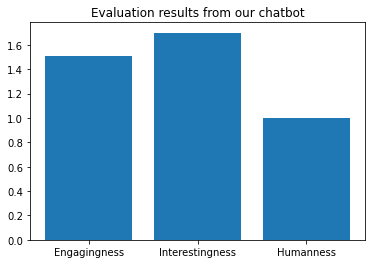

In [43]:
Evaluation_dim = ['Engagingness', 'Interestingness', 'Humanness']
print(f'Engagingness: {E_scores}\nInterestingness: {I_scores}\nHumanness: {H_scores}')

avgE = sum(E_scores) / len(E_scores)
avgI = sum(I_scores) / len(I_scores)
avgH = sum(H_scores) / len(H_scores)

Avg_scores = [avgE, avgI, avgH]

plt.bar(Evaluation_dim, Avg_scores)
plt.title('Evaluation results from our chatbot')
plt.show()

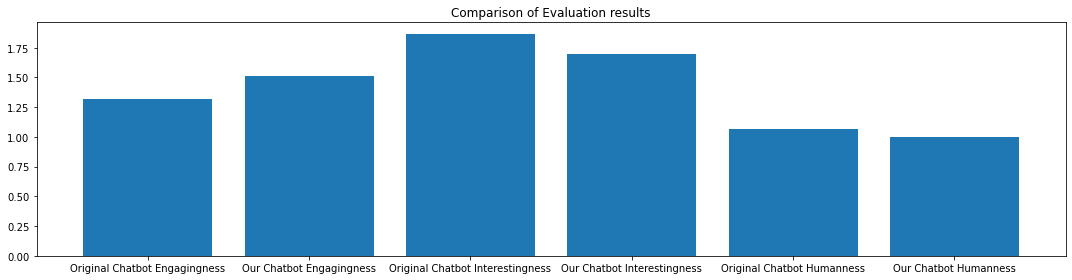

In [50]:
# Collected scores from the original chatbot
E_scoresOG = [1.2, 0.5, 0.8, 1.3, 2.0, 2.2, 1.5, 0.8, 0.9, 2.0]
I_scoresOG = [2.5, 1.6, 2.0, 1.1, 2.5, 2.5, 1.5, 1.5, 1.4, 2.1]
H_scoresOG = [1.5, 0.8, 1.4, 1.0, 1.1, 1.5, 0.8, 0.5, 0.5, 1.6]

Evaluation_dim = ['Original Chatbot Engagingness', 
                  'Our Chatbot Engagingness',
                  'Original Chatbot Interestingness', 
                  'Our Chatbot Interestingness',
                  'Original Chatbot Humanness',
                  'Our Chatbot Humanness']

OGavgE = sum(E_scoresOG) / len(E_scoresOG)
OGavgI = sum(I_scoresOG) / len(I_scoresOG)
OGavgH = sum(H_scoresOG) / len(H_scoresOG)

Avg_scores = [OGavgE, avgE, OGavgI, avgI, OGavgH, avgH]
fig = plt.figure(figsize=(15,4))
plt.bar(Evaluation_dim, Avg_scores)
plt.title('Comparison of Evaluation results')
fig.tight_layout()
plt.show()